# Validation of Horvath's probe depths

author: steeve.laquitaine@epfl.ch

We reconfigured a neuropixels probe from MEA to match Horvath's probe geometry. 

Method:
* use neuropixels probe template to create horvath probes

activate spikeinterf..

In [13]:
# listen to changes
%load_ext autoreload
%autoreload 2

import os

# set project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"

os.chdir(PROJ_PATH)

import logging
import logging.config
import shutil
from time import time
from matplotlib import pyplot as plt
import MEAutility as MEA
import numpy as np
import pandas as pd
import spikeinterface.extractors as se
import spikeinterface.full as si
import yaml
from probeinterface import generate_multi_columns_probe
from sklearn.decomposition import PCA

from src.nodes.dataeng.silico.filtering import (filter_microcircuit_cells,
                                                get_hex_01_cells)
from src.nodes.load import load_campaign_params
from src.nodes.validation.layer import getAtlasInfo

# SETUP PARAMETERS
from src.nodes.utils import get_config
EXPERIMENT = "silico_neuropixels"   # specifies the experiment 
SIMULATION_DATE = "concatenated"      # specifies the run (date)
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

# SETUP HORVATH PROBE PARAMETERS
N_COLS = 4
N_CONTACT_PER_COL = 32
X_PITCH = 22.5
Y_PITCH = 22.5
STAGGER = 0
SHAPE = "square"
WIDTH = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-06-08 14:15:02,862 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-08 14:15:02,926 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Created probe and center in a 7 cortical column-circuit

In [12]:
# create 2D ProbeInterface probe object
pi_ProbeNeuropix384_2D = generate_multi_columns_probe(
    num_columns=N_COLS,
    num_contact_per_column=N_CONTACT_PER_COL,
    xpitch=X_PITCH,
    ypitch=Y_PITCH,
    y_shift_per_column=[0, STAGGER, 0, STAGGER],
    contact_shapes=SHAPE,
    contact_shape_params={"width": WIDTH},
)

# make 3D
pi_ProbeNeuropix384_3D = pi_ProbeNeuropix384_2D.to_3d()

# center probe at (0,0,0)
# align probe with yz plane
pi_ProbeNeuropix384_3D.rotate(90, axis=[0, 0, 1])

# center probe's z axis at 0
pi_ProbeNeuropix384_3D.move(
    np.array(
        [-(X_PITCH * (N_COLS - 1)) / 2, 0, -(Y_PITCH * (N_CONTACT_PER_COL - 1)) / 2]
    )
)

# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111, projection="3d");
# ax.view_init(0,0,90);
# plot_probe(pi_ProbeNeuropix384_3D, ax=ax);
# plt.plot(0,0,0, "ro");

# get the campaign parameters from the first simulation
simulation = load_campaign_params(data_conf)

# get the microcircuit (hex0) cells to position the probe at its centroid
filtered_cells = get_hex_01_cells(simulation)
circuit_centroid = np.mean(filtered_cells["soma_location"], axis=0).values
pca = PCA(n_components=3)
pca.fit(filtered_cells["soma_location"])
main_axis = pca.components_[0]
elevation = np.arctan2(np.sqrt(main_axis[0] ** 2 + main_axis[1] ** 2), main_axis[2])
azimuth = np.arctan2(main_axis[1], main_axis[0])
pi_ProbeNeuropix384_3D.rotate(elevation * 180 / np.pi, axis=[0, 1, 0])
pi_ProbeNeuropix384_3D.rotate(azimuth * 180 / np.pi, axis=[0, 0, 1])
pi_ProbeNeuropix384_3D.move(circuit_centroid)

### Plot

circuit cell (count):  211712


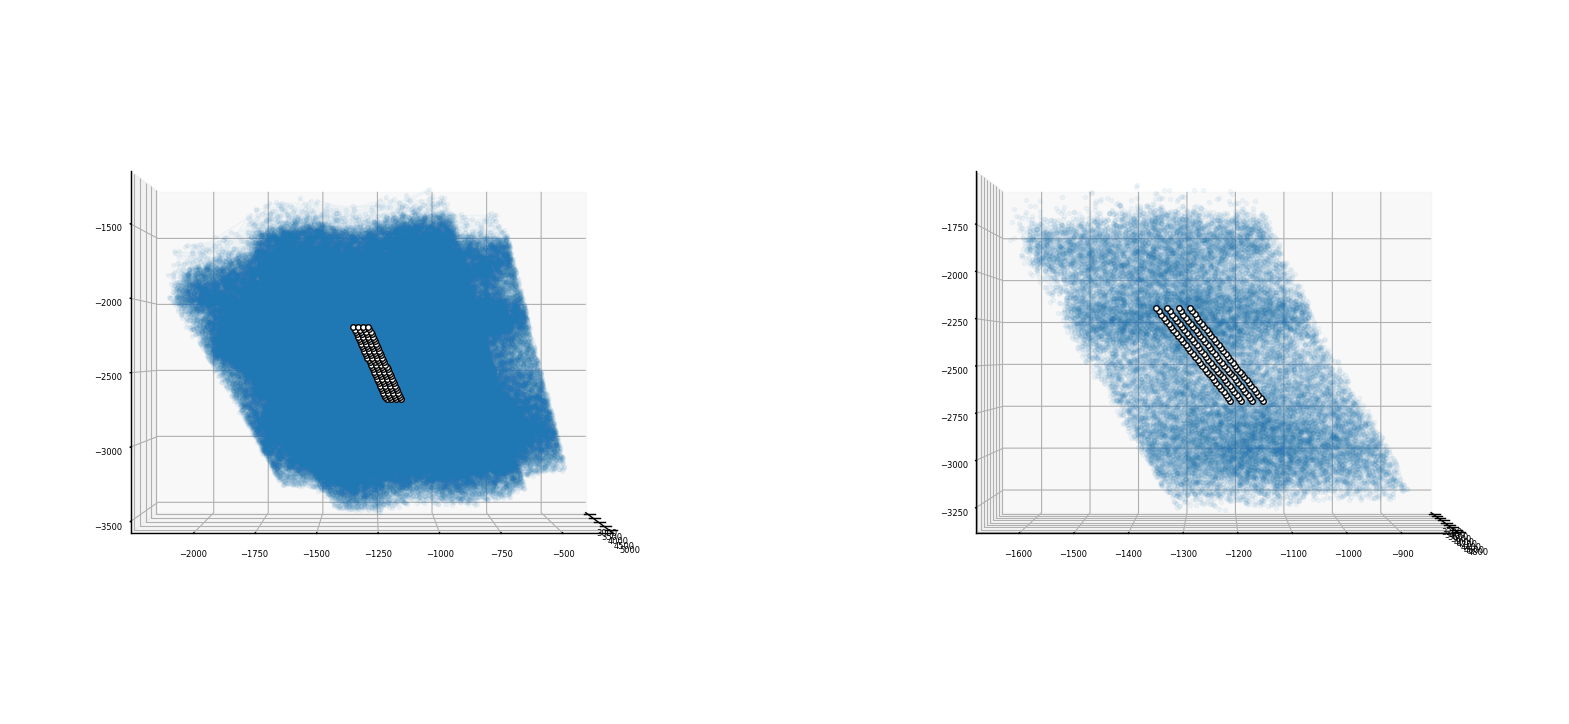

In [14]:
# get column circuit soma coord.
circuit = get_hex_01_cells(simulation)
print("circuit cell (count): ", len(circuit["soma_location"]))

fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(121, projection="3d")
ax.view_init(0, 0)

# plot cells
ax.plot(
    circuit["soma_location"].x,
    circuit["soma_location"].y,
    circuit["soma_location"].z,
    marker=".",
    alpha=0.05,
)

# plot probe contacts
ax.plot(
    pi_ProbeNeuropix384_3D.contact_positions[:, 0],
    pi_ProbeNeuropix384_3D.contact_positions[:, 1],
    pi_ProbeNeuropix384_3D.contact_positions[:, 2],
    marker=".",
    markersize=8,
    color="w",
    markeredgecolor="black",
    linestyle="None",
)

# get column circuit soma coord.
microcircuit = filter_microcircuit_cells(simulation)

# Plot single Column
ax = fig.add_subplot(122, projection="3d")
ax.view_init(0, 0)

# plot cells
ax.plot(
    microcircuit["soma_location"].x,
    microcircuit["soma_location"].y,
    microcircuit["soma_location"].z,
    ".",
    alpha=0.05,
)

# plot probe contacts
ax.plot(
    pi_ProbeNeuropix384_3D.contact_positions[:, 0],
    pi_ProbeNeuropix384_3D.contact_positions[:, 1],
    pi_ProbeNeuropix384_3D.contact_positions[:, 2],
    marker=".",
    markersize=8,
    color="w",
    markeredgecolor="black",
    linestyle="None",
)

### Match Horvath et al.,'s probe depths

- two to three depths to cover all cortical layers (see description nb)
    - depth 1 probe covers Out, L1 and L2/3
    - depth 2 probe covers L2/3, to L6 
    - depth 3 probe covers L5, to L6
- recording contacts slightly overlapping between probes from 20 to 100 microns
- depths are not in the wired probe's coordinates. The coordinates are the same (relative) for the three probes.
- channel labeling is done row-first which is a different from the usual column-first (for other neuropixels)

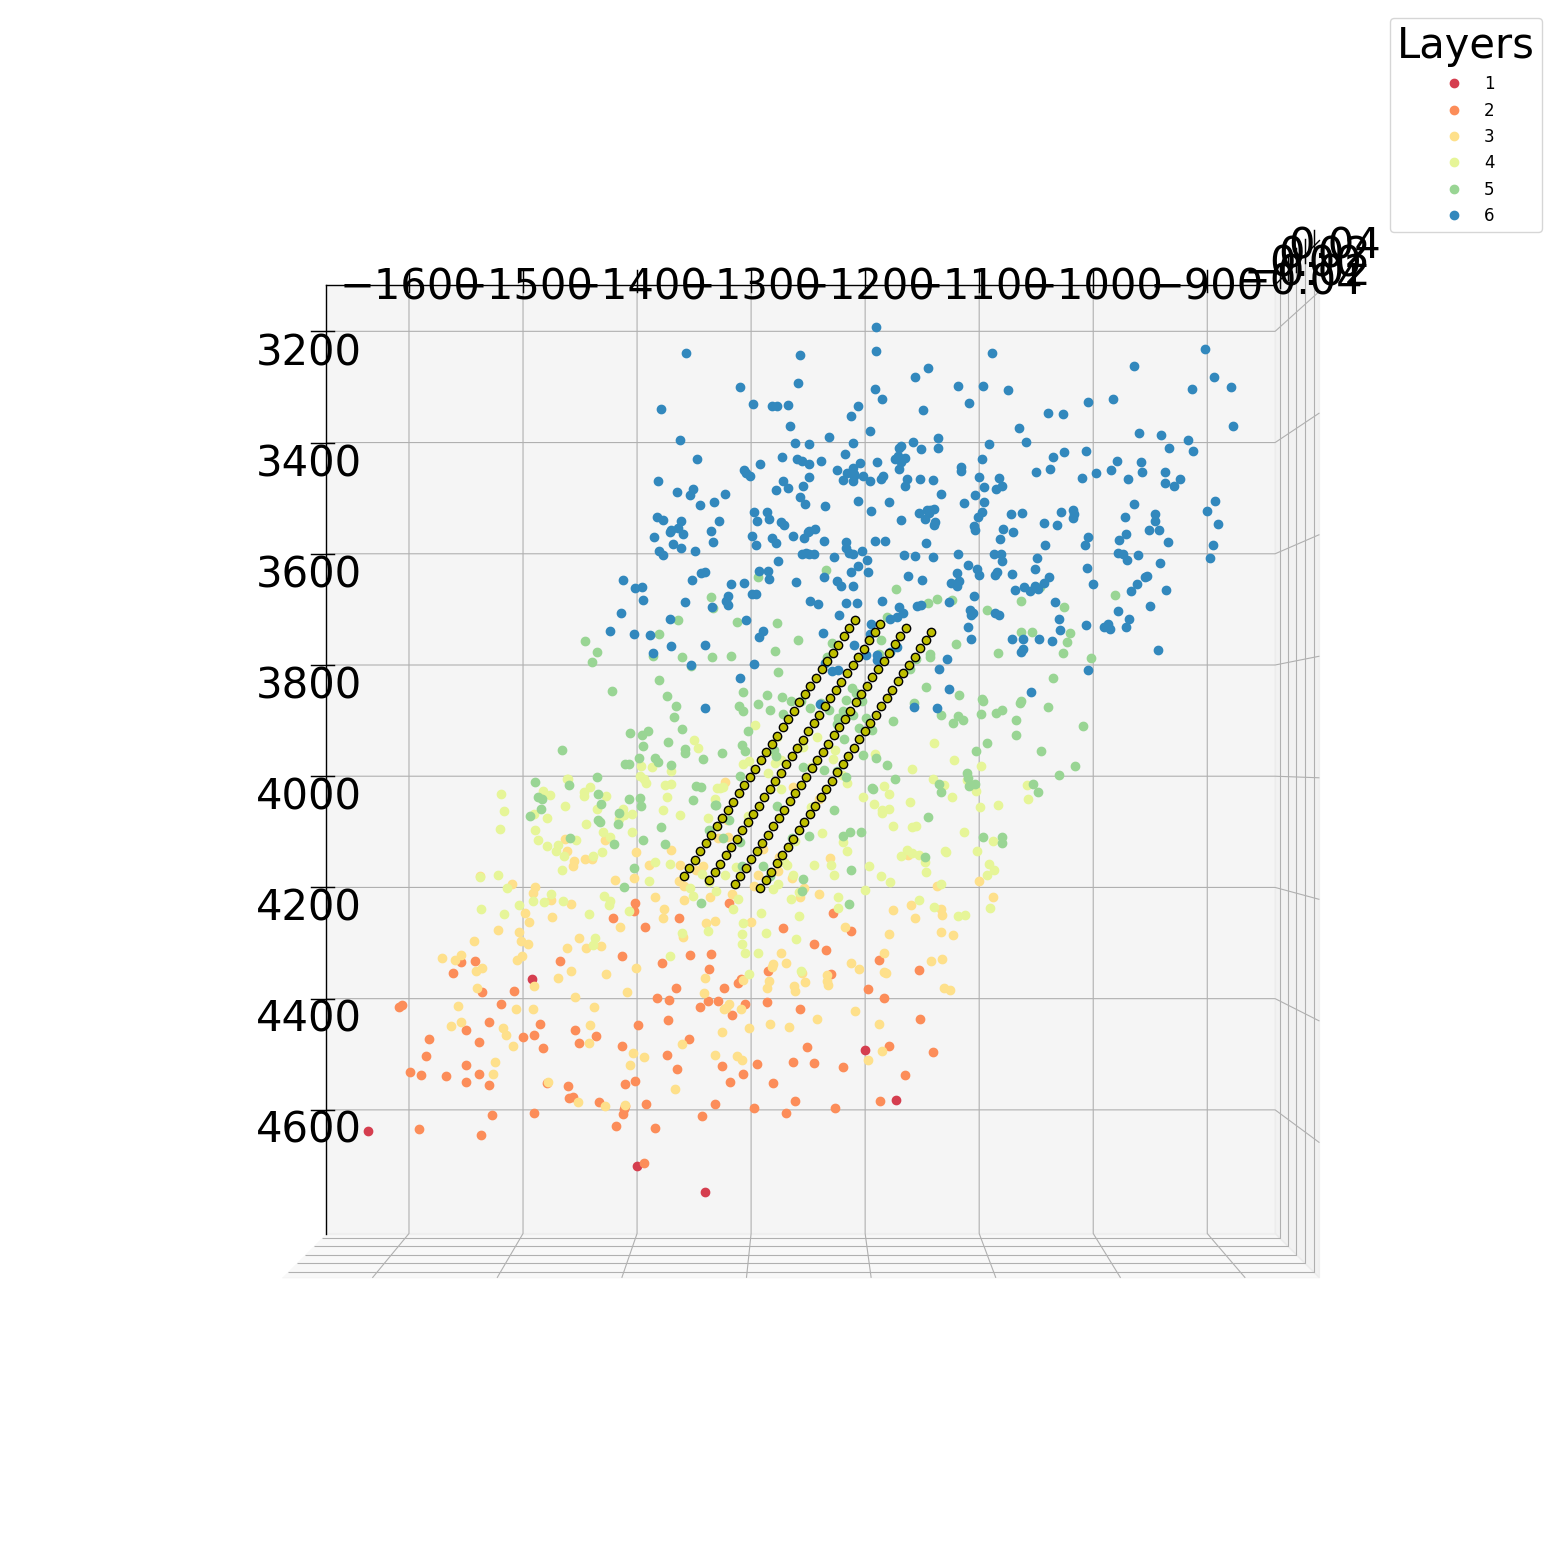

In [4]:
fig = plt.figure(figsize=(20, 20))

# setup plot
ax = fig.add_subplot(111, projection="3d")
ax.view_init(90, 0, 0)

microcircuit_coord = microcircuit["soma_location"].sample(
    n=1000, axis=0, random_state=1
)

# get cell layers
cell_layers = simulation["circuit"].cells.get(
    group=microcircuit["gid"], properties="layer"
)

# plot cells colored by layer
layer_color = [
    (0, 0, 0),
    (213 / 255, 62 / 255, 79 / 255),
    (252 / 255, 141 / 255, 89 / 255),
    (254 / 255, 224 / 255, 139 / 255),
    (230 / 255, 245 / 255, 152 / 255),
    (153 / 255, 213 / 255, 148 / 255),
    (50 / 255, 136 / 255, 189 / 255),
]

layers = np.sort(cell_layers.unique())

contact_ids = np.arange(0, 128)

for layer_i in layers:
    ax.plot(
        microcircuit_coord.x[cell_layers == layer_i],
        microcircuit_coord.y[cell_layers == layer_i],
        ".",
        color=layer_color[int(layer_i)],
        markersize=12,
    )


# add contacts
ax.plot(
    pi_ProbeNeuropix384_3D.contact_positions[:, 0],
    pi_ProbeNeuropix384_3D.contact_positions[:, 1],
    marker=".",
    markersize=12,
    color="y",
    markeredgecolor="black",
    linestyle="None",
)

legend = ax.legend(layers, fontsize=12, title="Layers")

### DEPTH 1

- We translated the probe in depth, along the main axis, to cover down to L2/3 but not L4.

- Counter({' L2/3': 60, ' L1': 36, ' Outside of the cortex': 32})

- we get max 28 electrodes in L1 without rotation, which is 12 less electrodes than horvath. We rotated the electrode to match Horvath electrode count.

Counter({'L2/3': 64, 'L1': 37, 'Outside': 27})

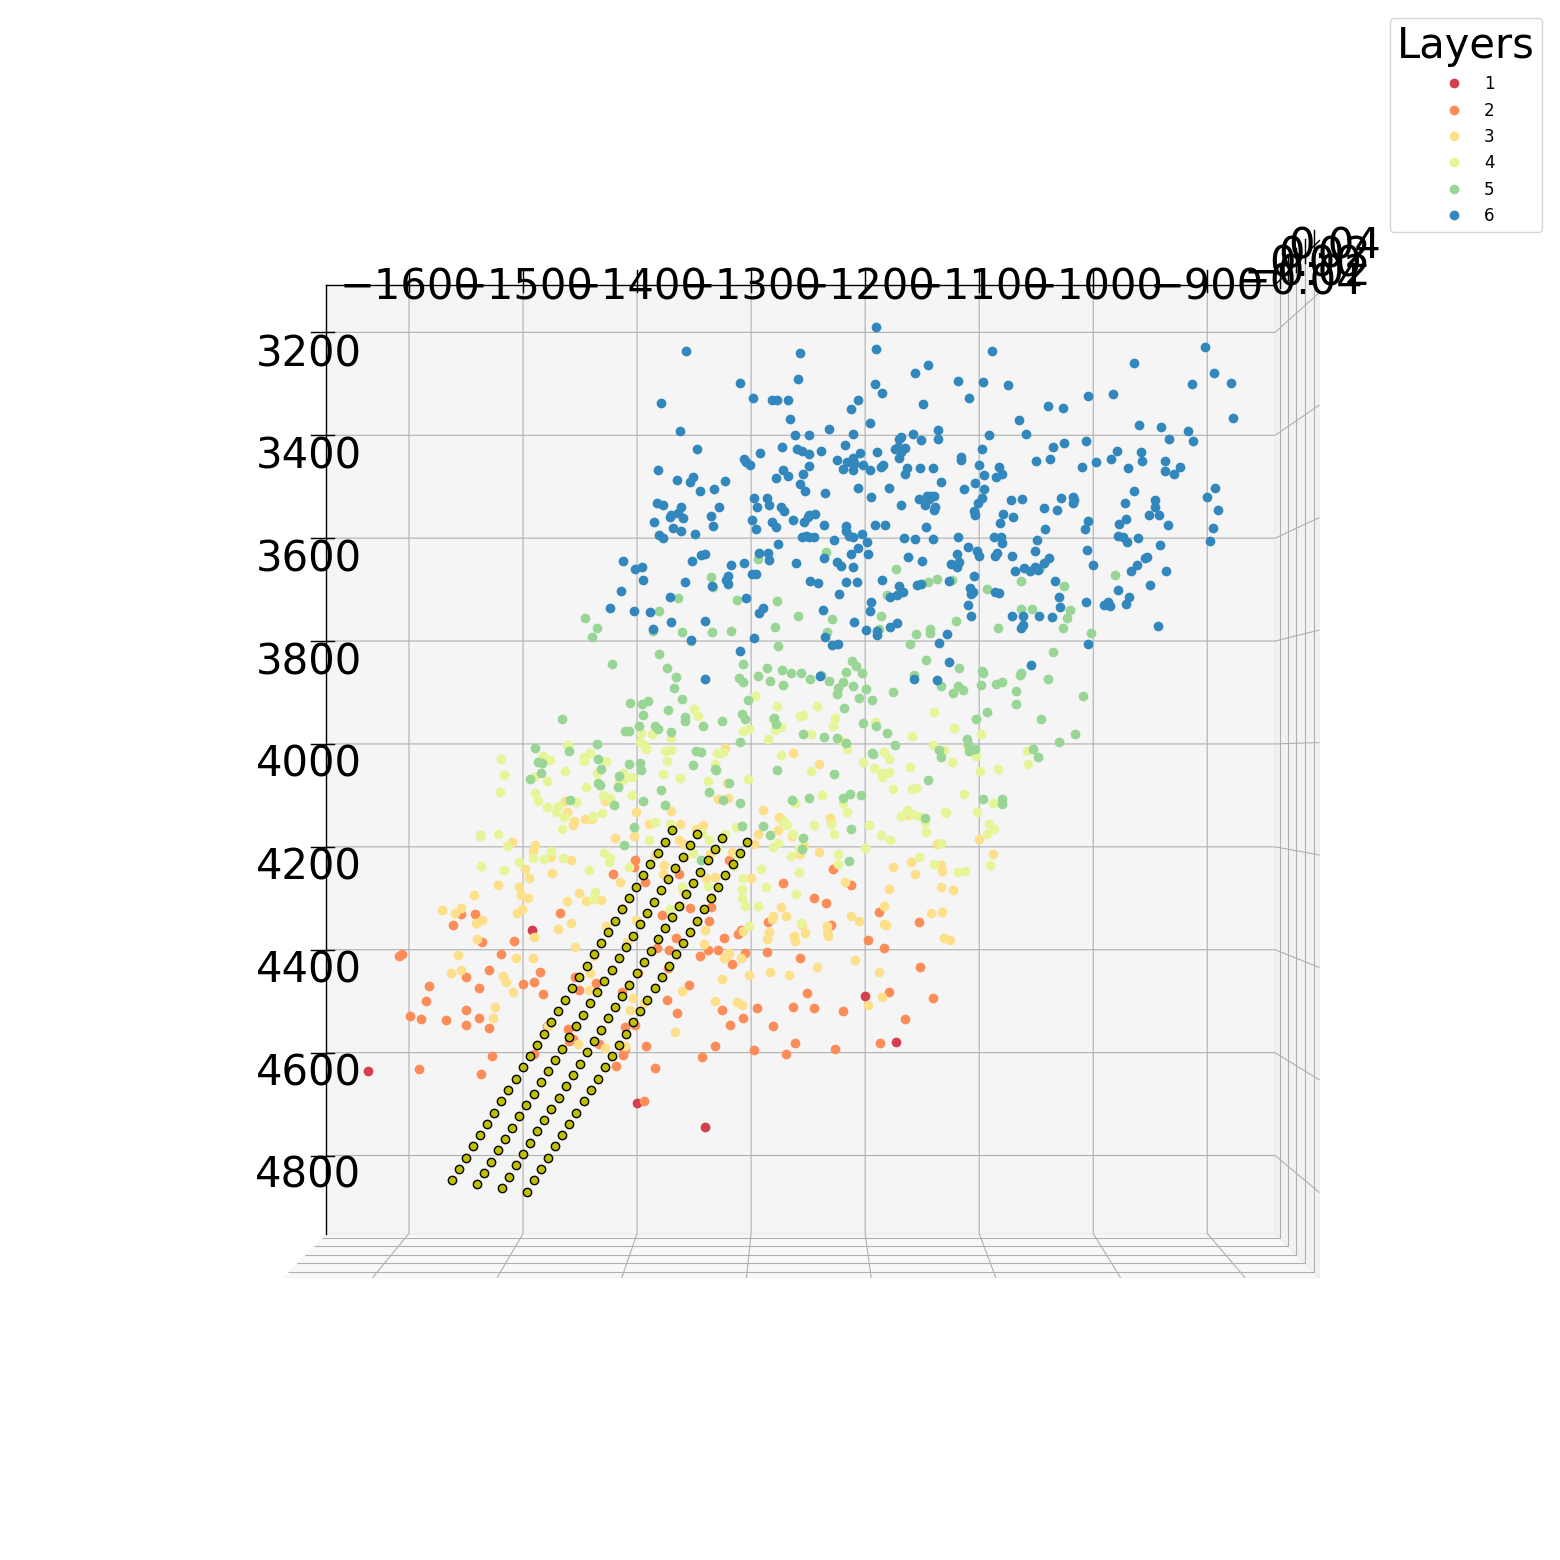

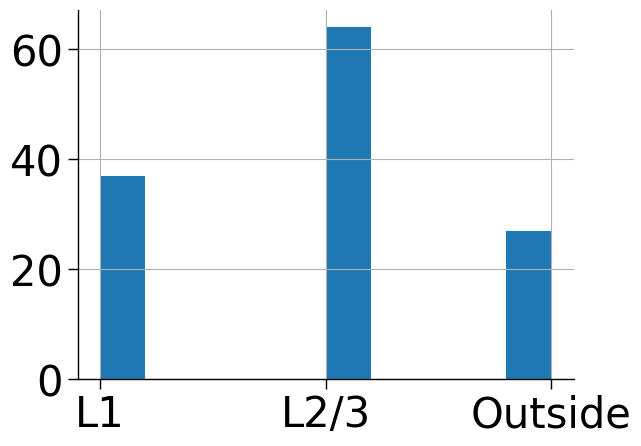

In [5]:
import copy

SHIFT_FROM_CENTER_1 = main_axis * 850
pi_ProbeNeuropix384_3D_2 = copy.deepcopy(pi_ProbeNeuropix384_3D)
# rotate at center then translate
pi_ProbeNeuropix384_3D_2.rotate(0.62 * 180 / np.pi, axis=[0, 1, 0])
pi_ProbeNeuropix384_3D_2.rotate(0.2 * azimuth * 180 / np.pi, axis=[0, 0, 1])
pi_ProbeNeuropix384_3D_2.move(SHIFT_FROM_CENTER_1)

fig = plt.figure(figsize=(20, 20))

# setup plot
ax = fig.add_subplot(111, projection="3d")
ax.view_init(90, 0, 0)

for layer_i in layers:
    ax.plot(
        microcircuit_coord.x[cell_layers == layer_i],
        microcircuit_coord.y[cell_layers == layer_i],
        ".",
        color=layer_color[int(layer_i)],
        markersize=12,
    )

# add contacts
ax.plot(
    pi_ProbeNeuropix384_3D_2.contact_positions[:, 0],
    pi_ProbeNeuropix384_3D_2.contact_positions[:, 1],
    marker=".",
    markersize=12,
    color="y",
    markeredgecolor="black",
    linestyle="None",
)
legend = ax.legend(layers, fontsize=12, title="Layers")

# report layers covered
out = getAtlasInfo(
    data_conf["dataeng"]["blueconfig"], pi_ProbeNeuropix384_3D_2.contact_positions
)

# electrodes per site
# - merge layers 2 and 3
plt.figure()
location_1 = pd.Series(out[1]).sort_values()
location_1[location_1 == "L2"] = "L2/3"
location_1[location_1 == "L3"] = "L2/3"
location_1.hist()

from collections import Counter

# Counter({' L2/3': 60, ' L1': 36, ' Outside of the cortex': 32})
Counter(location_1)

### DEPTH 2

- L2/3 to L6 

- electrode per layer {' L5': 88, ' L4': 20, ' L6': 12, ' L2/3': 8}

Counter({'L5': 88, 'L4': 32, 'L2/3': 8})

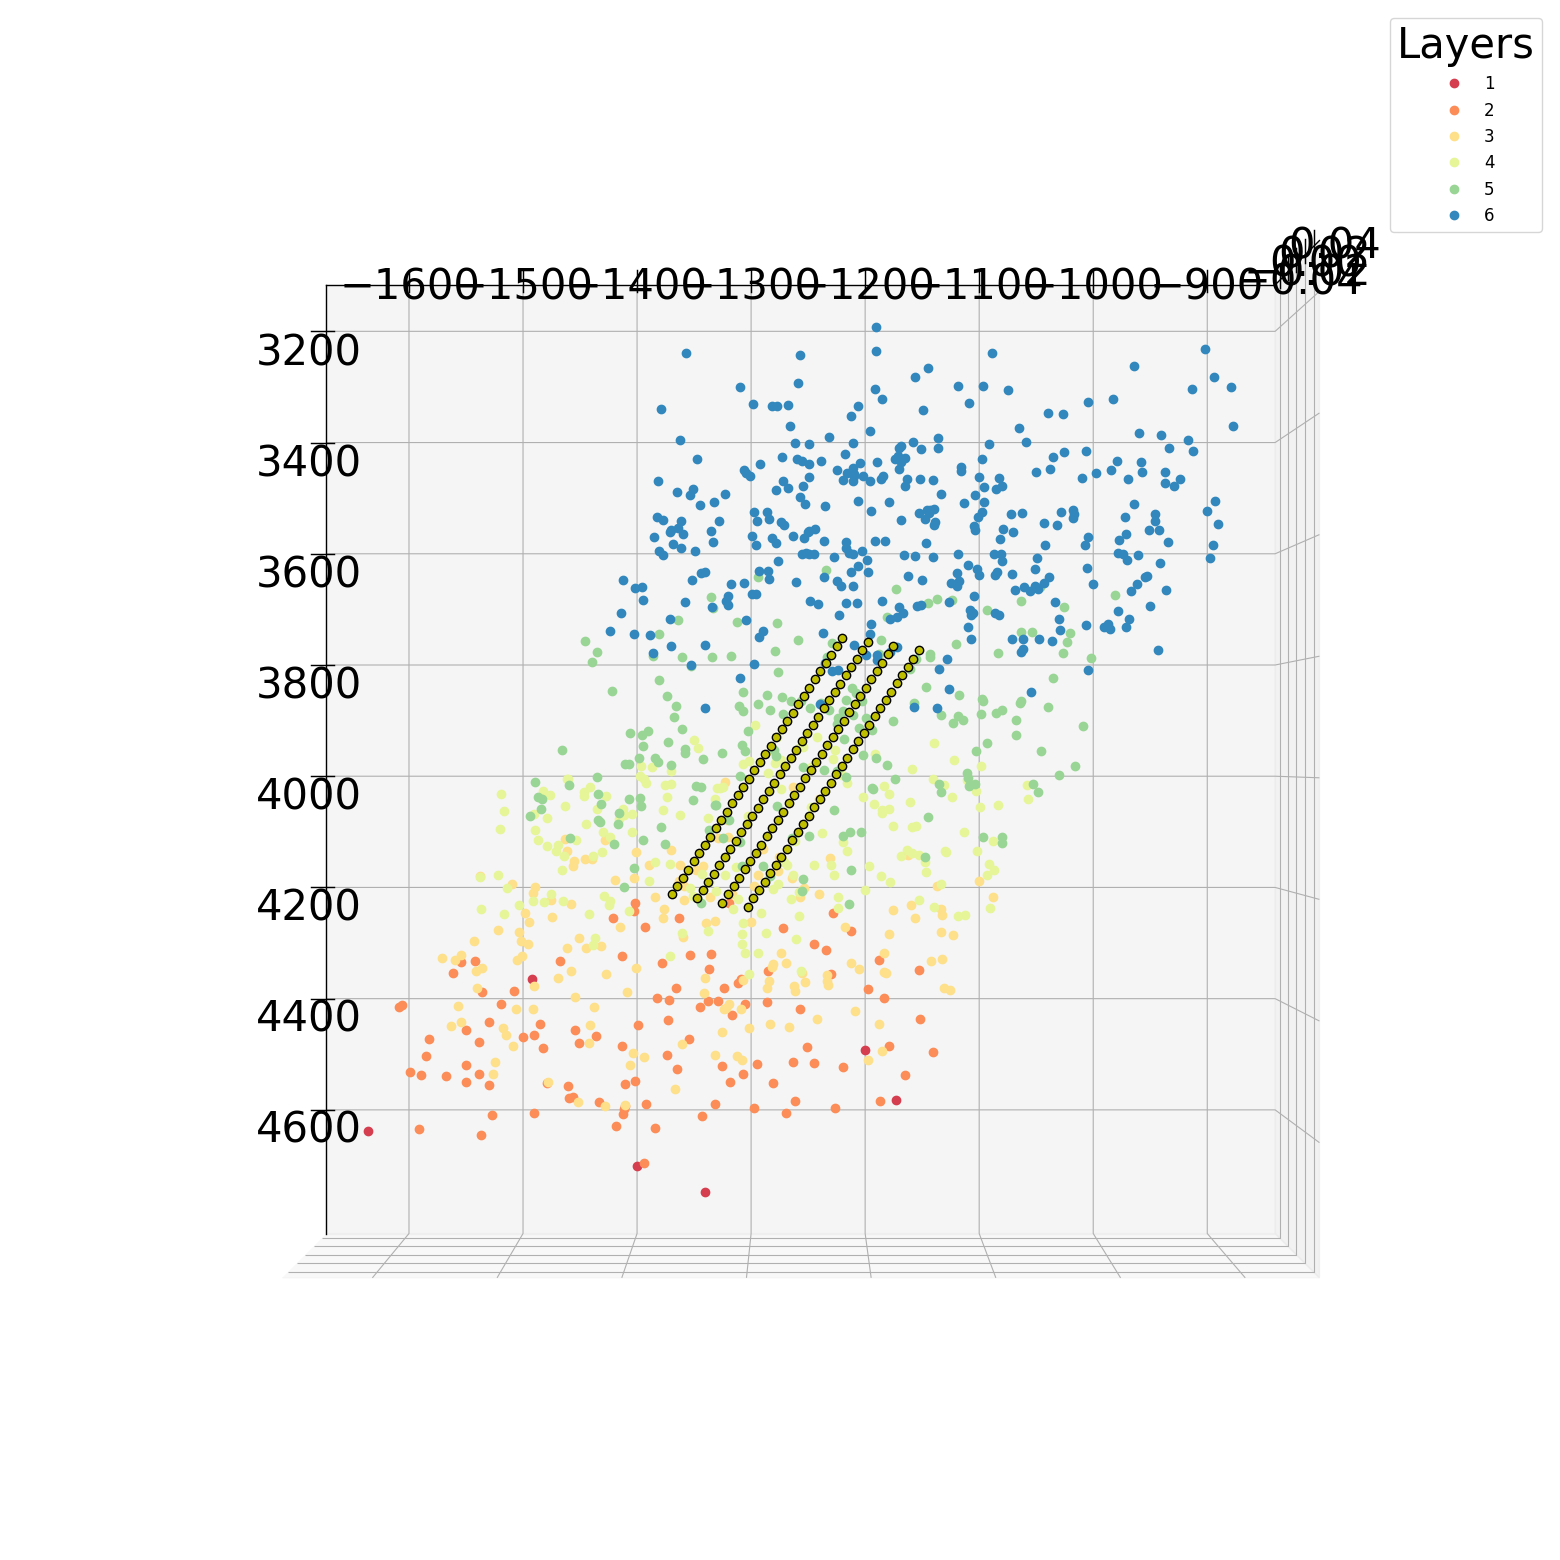

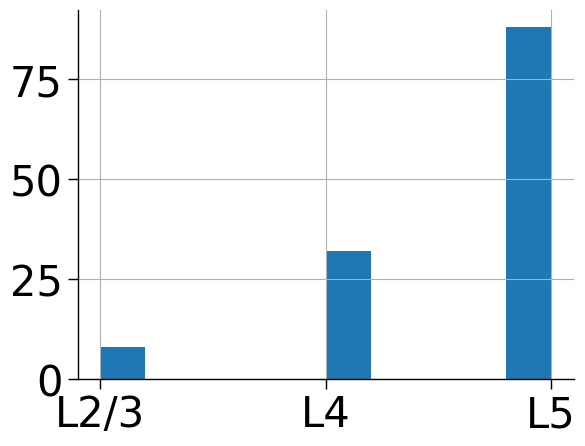

In [6]:
import copy

# rotate at center then translate
SHIFT_FROM_DEPTH_1 = -main_axis * 800
pi_ProbeNeuropix384_3D_3 = copy.deepcopy(pi_ProbeNeuropix384_3D)
pi_ProbeNeuropix384_3D_3.move(SHIFT_FROM_CENTER_1 + SHIFT_FROM_DEPTH_1)

fig = plt.figure(figsize=(20, 20))

# setup plot
ax = fig.add_subplot(111, projection="3d")
ax.view_init(90, 0, 0)

for layer_i in layers:
    ax.plot(
        microcircuit_coord.x[cell_layers == layer_i],
        microcircuit_coord.y[cell_layers == layer_i],
        ".",
        color=layer_color[int(layer_i)],
        markersize=12,
    )

# add contacts
ax.plot(
    pi_ProbeNeuropix384_3D_3.contact_positions[:, 0],
    pi_ProbeNeuropix384_3D_3.contact_positions[:, 1],
    marker=".",
    markersize=12,
    color="y",
    markeredgecolor="black",
    linestyle="None",
)
legend = ax.legend(layers, fontsize=12, title="Layers")

# report layers covered
out = getAtlasInfo(
    data_conf["dataeng"]["blueconfig"], pi_ProbeNeuropix384_3D_3.contact_positions
)

# electrodes per site
plt.figure()
location_2 = pd.Series(out[1]).sort_values()
location_2[location_2 == "L2"] = "L2/3"
location_2[location_2 == "L3"] = "L2/3"
location_2.hist()

# Counter({' L5': 88, ' L4': 20, ' L6': 12, ' L2/3': 8})
Counter(location_2)

### DEPTH 3

- L6 to Outside

- Counter({' L6': 68, ' Outside of the cortex': 60})

['L6' 'Outside']


Counter({'L6': 76, 'Outside': 52})

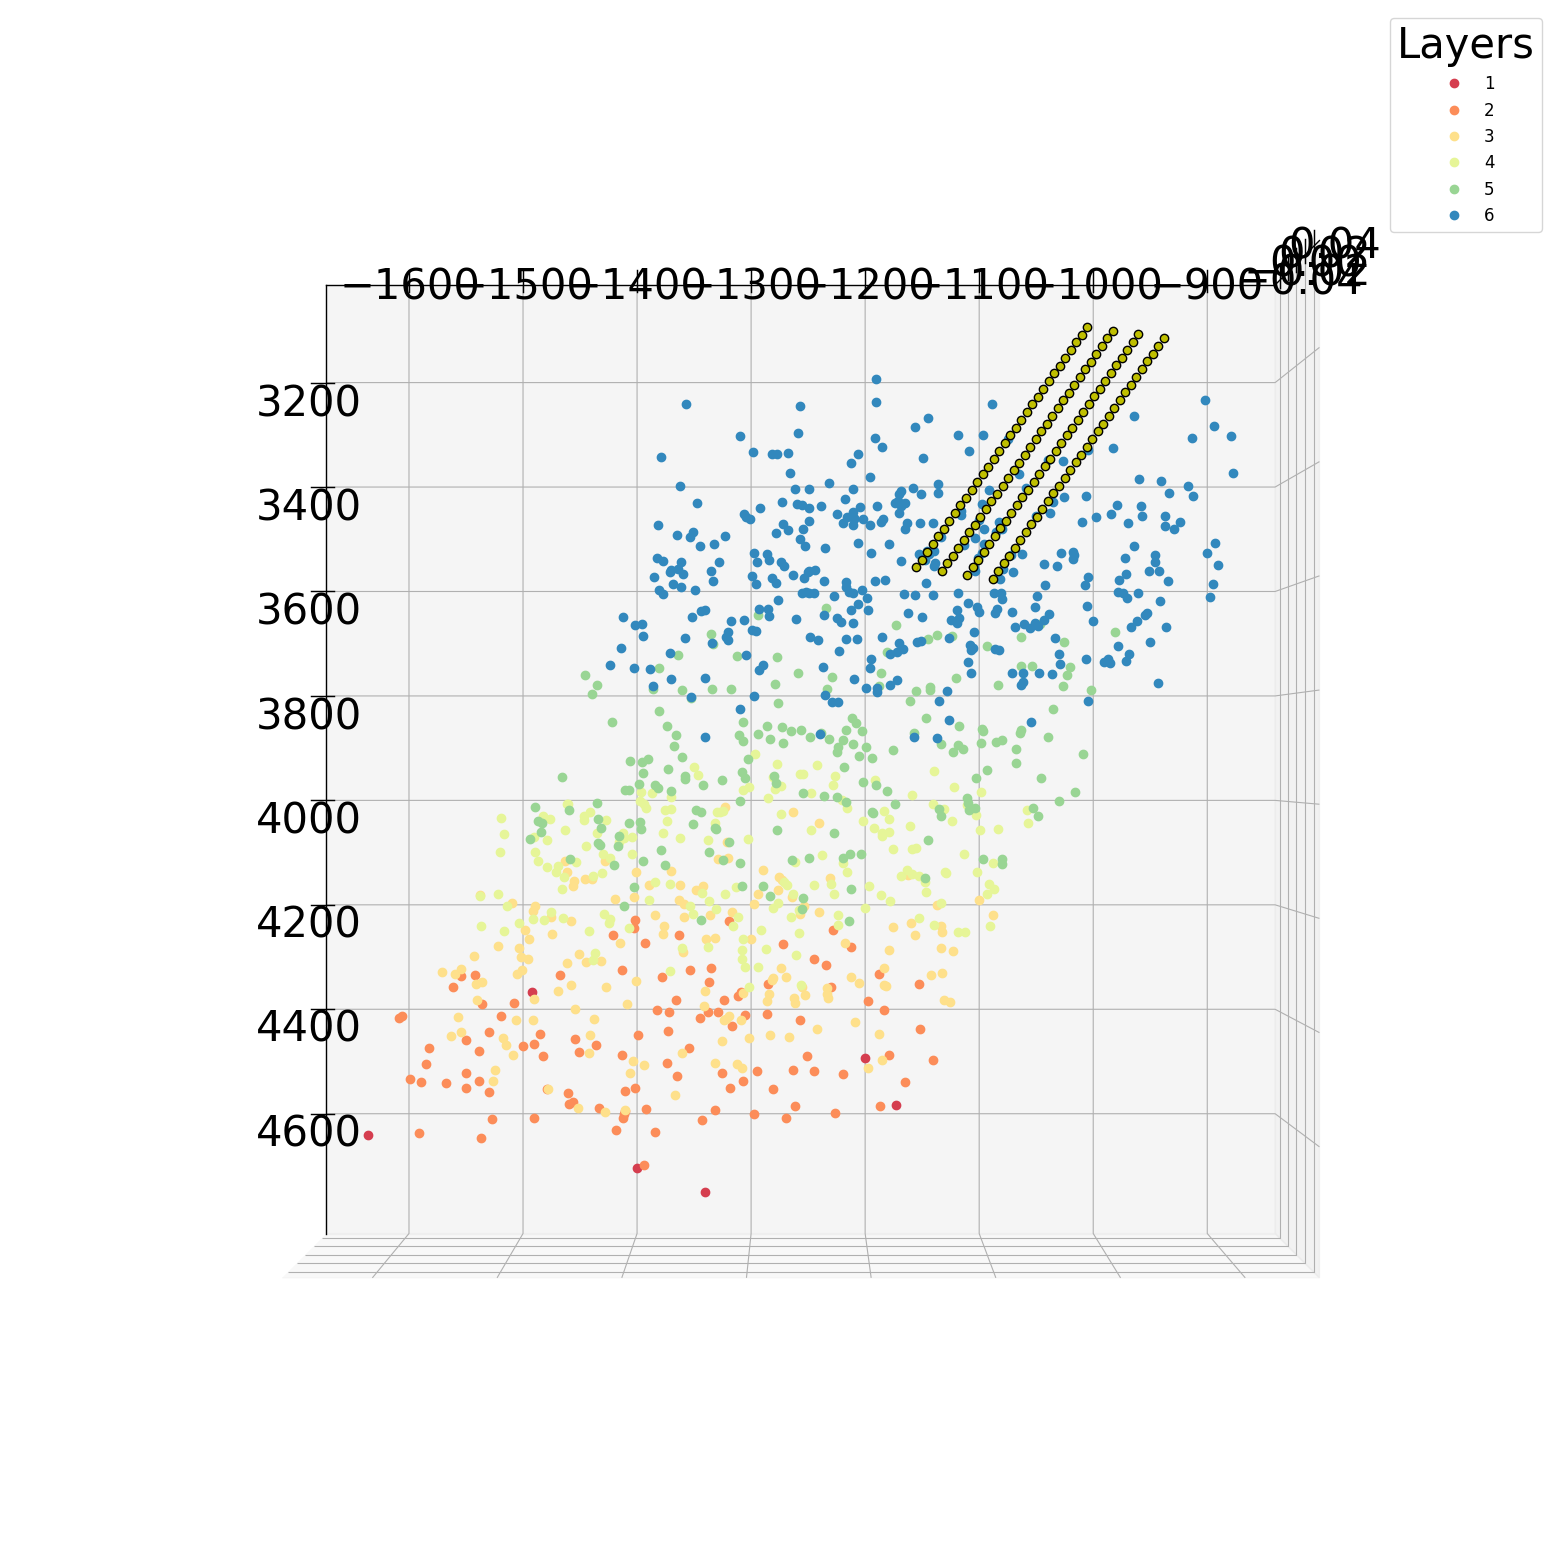

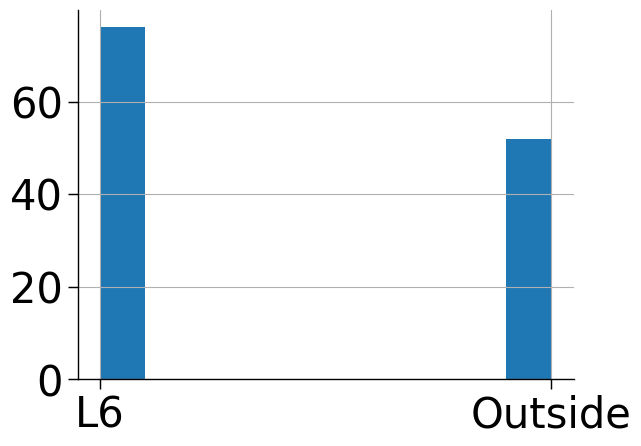

In [7]:
# rotate at center then translate
SHIFT_FROM_DEPTH_2 = -main_axis * 1000
pi_ProbeNeuropix384_3D_4 = copy.deepcopy(pi_ProbeNeuropix384_3D)
pi_ProbeNeuropix384_3D_4.move(
    SHIFT_FROM_CENTER_1 + SHIFT_FROM_DEPTH_1 + SHIFT_FROM_DEPTH_2
)

fig = plt.figure(figsize=(20, 20))

# setup plot
ax = fig.add_subplot(111, projection="3d")
ax.view_init(90, 0, 0)

for layer_i in layers:
    ax.plot(
        microcircuit_coord.x[cell_layers == layer_i],
        microcircuit_coord.y[cell_layers == layer_i],
        ".",
        color=layer_color[int(layer_i)],
        markersize=12,
    )

# add contacts
ax.plot(
    pi_ProbeNeuropix384_3D_4.contact_positions[:, 0],
    pi_ProbeNeuropix384_3D_4.contact_positions[:, 1],
    marker=".",
    markersize=12,
    color="y",
    markeredgecolor="black",
    linestyle="None",
)
legend = ax.legend(layers, fontsize=12, title="Layers")

# report layers covered
out = getAtlasInfo(
    data_conf["dataeng"]["blueconfig"], pi_ProbeNeuropix384_3D_4.contact_positions
)
print(np.unique(out[1]))

# electrodes per site
plt.figure()
location_3 = pd.Series(out[1]).sort_values()
location_3[location_3 == "L2"] = "L2/3"
location_3[location_3 == "L3"] = "L2/3"
location_3.hist()

# Counter({' L6': 68, ' Outside of the cortex': 60})
Counter(location_3)

- DEPTH_1 Counter({' L2/3': 60, ' L1': 36, ' Outside of the cortex': 32})
- DEPTH 2 Counter({' L5': 88, ' L4': 20, ' L6': 12, ' L2/3': 8})
- DEPTH 3 Counter({' L6': 68, ' Outside of the cortex': 60})

### Compare

In [26]:
# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.05)
COLOR_VIVO = np.array([153, 153, 153]) / 255
COLOR_SILI = np.array([228, 26, 28]) / 255
COLOR_BUCCI = np.array([55, 126, 184]) / 255
FIT_BAND2 = np.array([152, 78, 163]) / 255
FIT_BAND3 = np.array([255, 127, 0]) / 255
BOX_ASPECT = 1  # square fig
LG_FRAMEON = False  # no legend frame
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 1.1
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["xtick.major.width"] = 0.8 * 1.3
plt.rcParams["ytick.major.width"] = 0.8 * 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 2
plt.rcParams["xtick.minor.size"] = 2 * 2
plt.rcParams["ytick.major.size"] = 3.5 * 2
plt.rcParams["ytick.minor.size"] = 2 * 2

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent": True, "dpi": 300}  # dpi=300 minimum for publication
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

  layers  count
0     L1     36
1   L2/3     68
2     L4     20
3     L5     88
4     L6     80
5    Out     92
L1         37
L2/3       72
L4         32
L5         88
L6         76
Outside    79
dtype: int64


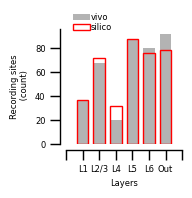

In [27]:
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# Horvath's experimental site locations
all_true_locations = pd.DataFrame.from_dict(
    {
        "layers": ["L1", "L2/3", "L4", "L5", "L6", "Out"],
        "count": [36, 60 + 8, 20, 88, 68 + 12, 32 + 60],
    },
    orient="columns",
)

# plot
ax.bar(
    x=np.arange(1, 7, 1),
    height=all_true_locations["count"],
    label="vivo",
    width=0.7,
    facecolor=(0.7, 0.7, 0.7),
)
print(all_true_locations)

# simulated site location
all_locations = pd.concat([location_1, location_2, location_3]).sort_values()
all_location_counts = pd.Series(Counter(all_locations))

# plot
ax.bar(
    x=np.arange(1, 7, 1),
    height=all_location_counts.values,
    label="silico",
    width=0.7,
    facecolor="None",
    edgecolor="r",
)
print(all_location_counts)

# legend
ax.legend(
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(0, 1.2),
    handletextpad=0.1,
    labelspacing=0.1,
)
ax.set_ylabel("Recording sites\n (count)")
ax.set_xlabel("Layers")
ax.spines[["top", "right"]].set_visible(False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_xticks(np.arange(0, 8, 1), ["", "L1", "L2/3", "L4", "L5", "L6", "Out", ""])
ax.set_xlim([0, 7])

# save figure at publication size
plt.savefig(
    "figures/6_supp/fig1/svg/horvath_probe.svg",
    **savefig_cfg,
)

# References 

https://bbpgitlab.epfl.ch/conn/personal/tharayil/eeg-for-neurodamus/-/blob/master/parallel/testNew/writeH5_MPI_prelim_reyespuerta.py